# Process BIOLOG data

Parse the BIOLOG data cumulated from multiple studies, and explore associations between taxonomy and metabolism.

**Studies data was retrieved from:**


Looking for metric distances between the genomes, but handling more categorical rather than

## Imports

In [10]:
import pandas as pd

from copy import copy

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import adjustText

from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

from cazomevolve.cazome.explore.pca import (
    perform_pca,
    plot_explained_variance,
    plot_scree,
    plot_pca,
    plot_loadings,
)

## Load data

In [2]:
biolog_df = pd.read_csv("../data/pecto_dic/pd-carbon-utilisation-v14.csv", index_col=0)
biolog_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,Reference,"Jee et al., 2020","Jee et al., 2020","Jee et al., 2020","Jee et al., 2020","Jee et al., 2020","Jee et al., 2020","Moussa et al., 2021","Moussa et al., 2021","Moussa et al., 2021",...,"Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019","Waleron et al., 2019"
1,Species,P.brasiliense,P. carotovorum,P.odoriferum,P.parmentieri,P.polaris,P.versatile,P.aquaticum,P.quasiaquaticum,P.quasiaquaticum,...,P.polonicum,P.polonicum,P.punjabese,P.wasabiae,P.wasabiae,P.parmentieri,P.parmentieri,P.peruviense,P.atrosepticum,P.zatedeschiae
2,Carbon source,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Separate out the species and genus data, and transpose the dataframe so that each column is a unique carbon source/biochemical test.

In [3]:
column_names = biolog_df['0']
biolog_df = biolog_df.drop('0', axis=1)
biolog_df = biolog_df.T  # transpose the dataframe
biolog_df.columns = column_names
biolog_df = biolog_df.drop('Carbon source', axis=1)
biolog_df.head(3)

0,Reference,Species,1% NaCl,1% Sodium Lactate,3-O-Methyl-D-Glucose,4% NaCl,8% NaCl,Acetic Acid,Acetoacetic Acid,Aztreonam,...,Ala-gly,Gly-asn,ethanolamine,agmatine,Ala-lue,allantoin,Ala-thr,M-TartaricAcid,D-galactonic acid gamma-Lactone,Gly-Pro
1,"Jee et al., 2020",P.brasiliense,0,0,0,+,0,0,0,-,...,0,0,0,0,0,0,0,0,0,0
2,"Jee et al., 2020",P. carotovorum,0,0,0,+,0,0,0,-,...,0,0,0,0,0,0,0,0,0,0
3,"Jee et al., 2020",P.odoriferum,0,0,0,+,0,0,0,-,...,0,0,0,0,0,0,0,0,0,0


In [4]:
species_col, genus_col = [], []

for data in tqdm(list(biolog_df['Species']), desc="Extracting tax data"):
    genus = data.split(".")[0].strip()
    if genus == 'P':
        genus = 'Pectobacterium'
    else:
        genus = 'Dickeya'
    sp = data.split(".")[1].strip()    
    
    species_col.append(sp)
    genus_col.append(genus)
    
biolog_df['Species'] = species_col
biolog_df['Genus'] = genus_col

biolog_df.head(3)

Extracting tax data:   0%|          | 0/120 [00:00<?, ?it/s]

0,Reference,Species,1% NaCl,1% Sodium Lactate,3-O-Methyl-D-Glucose,4% NaCl,8% NaCl,Acetic Acid,Acetoacetic Acid,Aztreonam,...,Gly-asn,ethanolamine,agmatine,Ala-lue,allantoin,Ala-thr,M-TartaricAcid,D-galactonic acid gamma-Lactone,Gly-Pro,Genus
1,"Jee et al., 2020",brasiliense,0,0,0,+,0,0,0,-,...,0,0,0,0,0,0,0,0,0,Pectobacterium
2,"Jee et al., 2020",carotovorum,0,0,0,+,0,0,0,-,...,0,0,0,0,0,0,0,0,0,Pectobacterium
3,"Jee et al., 2020",odoriferum,0,0,0,+,0,0,0,-,...,0,0,0,0,0,0,0,0,0,Pectobacterium


In [5]:
biolog_df = biolog_df.drop('Reference', axis=1)
biolog_df_gs = biolog_df.set_index(['Genus', 'Species'])
biolog_df_gs.head(3)

0                          1% NaCl 1% Sodium Lactate 3-O-Methyl-D-Glucose   
Genus          Species                                                      
Pectobacterium brasiliense       0                 0                    0  \
               carotovorum       0                 0                    0   
               odoriferum        0                 0                    0   

0                          4% NaCl 8% NaCl Acetic Acid Acetoacetic Acid   
Genus          Species                                                    
Pectobacterium brasiliense       +       0           0                0  \
               carotovorum       +       0           0                0   
               odoriferum        +       0           0                0   

0                          Aztreonam Bromo-Succinic Acid Citric Acid  ...   
Genus          Species                                                ...   
Pectobacterium brasiliense         -                   0           +  ...  \
               carotovorum         -                   0           +  ...   
               odoriferum          -                   0           +  ...   

0                          Ala-gly Gly-asn ethanolamine agmatine Ala-lue   
Genus          Species                                                     
Pectobacterium brasiliense       0       0            0        0       0  \
               carotovorum       0       0            0        0       0   
               odoriferum        0       0            0        0       0   

0                          allantoin Ala-thr M-TartaricAcid   
Genus          Species                                        
Pectobacterium brasiliense         0       0              0  \
               carotovorum         0       0              0   
               odoriferum          0       0              0   

0                          D-galactonic acid gamma-Lactone Gly-Pro  
Genus          Species                                              
Pectobacterium brasiliense                               0       0  
               carotovorum                               0       0  
               odoriferum                                0       0  

[3 rows x 265 columns]

# Multidimensional Scaling

Use multidimensional scaling (MDS) to explore the distances (degree of similarirty) between the metabolisms of _Pectobacterium_ and _Dickeya_ species.

## Designing a scoring system

There are several ways to 'score' the BIOLOG data.

Positive and weak results can be represented by positive values, with positive hits represented with a larger or more positive value.

Negative results can either be represented with a negative value or a null value; the negative value could be negative equivalent of the positive or weak value.

Unknown or unrecorded values can be represented with a null value, so as to minimise the contribution to distances as the result of not recording a condition (i.e. processing of a carbon source) for a specific genome.

Proposed scoring systems:  

**Scoreing system 1:**
* 2 - positive
* 1 - weak
* 0 - unknown / not recorded
* 0 - negative

**Scoring system 2:**  
* 2 - positive
* 1 - weak
* 0 - unknown / not recorded
* -1 - negative

**Scoring system 3:**  
* 2 - positive
* 1 - weak
* 0 - unknown / not recorded
* -2 - negative

Each scoring system was tried on the complete data set.

Needs to reflect biology.

Or 1, 0 and -1.

In [6]:
def plot_mds(scaled_df, df_gs, genus_col, species_col):
    """Generate scatter plots of the MDS output, colour coding genomes by genus and species taxa
    
    :param scaled_df: MDS output instance
    :param df_gs: df used for MDS with genus and species data as the index
    :param genus_col: list of genus classifications for the genomes in df_gs
    :param species_col: list of species classifications for the genomes in df_gs

    Return nothing
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6));

    df_gs['Genus'] = genus_col
    g_mds_scatter = sns.scatterplot(
        x=scaled_df[:,0],
        y=scaled_df[:,1],
        data=df_gs,
        hue='Genus',
        style='Genus',
        s=80,
        ax=ax1,
    );

    g_mds_scatter.axhline(0, linestyle='--', color='grey', linewidth=1.25);
    g_mds_scatter.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    sns.move_legend(
        g_mds_scatter,
        "lower center",
        bbox_to_anchor=(.5, 1),
        ncol=3,
        title='Genus',
        frameon=False,
    );

    df_gs['Species'] = species_col

    

### Scoring system 1

* 3 - positive
* 2 - weak
* 0 - unknown / not recorded
* 0 - negative

In this scoring system negative results are given a score of 0. It could be argued that a negative result could be given a negative number so as to increase dissimilarity between a genome with a positive hit and a genome with a negative hit. However, the BIOLOG results are variable and can be subjective. What is a negative result? Is a negative result potentionally an extremely weak positive result that was not detected?

In [7]:
# replace the symbols with the appropriate score
biolog_df_gs_sys_1 = copy(biolog_df_gs)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('0', 0)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('-', -1)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('w', 1)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('+', 1)
biolog_df_gs_sys_1.head(3)

0                           1% NaCl  1% Sodium Lactate  3-O-Methyl-D-Glucose   
Genus          Species                                                         
Pectobacterium brasiliense        0                  0                     0  \
               carotovorum        0                  0                     0   
               odoriferum         0                  0                     0   

0                           4% NaCl  8% NaCl  Acetic Acid  Acetoacetic Acid   
Genus          Species                                                        
Pectobacterium brasiliense        1        0            0                 0  \
               carotovorum        1        0            0                 0   
               odoriferum         1        0            0                 0   

0                           Aztreonam  Bromo-Succinic Acid  Citric Acid  ...   
Genus          Species                                                   ...   
Pectobacterium brasiliense         -1                    0            1  ...  \
               carotovorum         -1                    0            1  ...   
               odoriferum          -1                    0            1  ...   

0                           Ala-gly  Gly-asn  ethanolamine  agmatine  Ala-lue   
Genus          Species                                                          
Pectobacterium brasiliense        0        0             0         0        0  \
               carotovorum        0        0             0         0        0   
               odoriferum         0        0             0         0        0   

0                           allantoin  Ala-thr  M-TartaricAcid   
Genus          Species                                           
Pectobacterium brasiliense          0        0               0  \
               carotovorum          0        0               0   
               odoriferum           0        0               0   

0                           D-galactonic acid gamma-Lactone  Gly-Pro  
Genus          Species                                                
Pectobacterium brasiliense                                0        0  
               carotovorum                                0        0  
               odoriferum                                 0        0  

[3 rows x 265 columns]

In [13]:
manhattan = sklearn.metrics.pairwise.manhattan_distances(biolog_df_gs_sys_1)

In [14]:
mds_1 = MDS(random_state=0, normalized_stress='auto')  # embedding
scaled_df_1 = mds_1.fit_transform(manhattan)
mds_1.stress_
#plot_mds(scaled_df_1, biolog_df_gs_sys_1, list(biolog_df['Genus']), list(biolog_df['Species']))

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


18955592.168749887

<ipython-input-6-cf8ca9694057>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Genus'] = genus_col
<ipython-input-6-cf8ca9694057>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Species'] = species_col


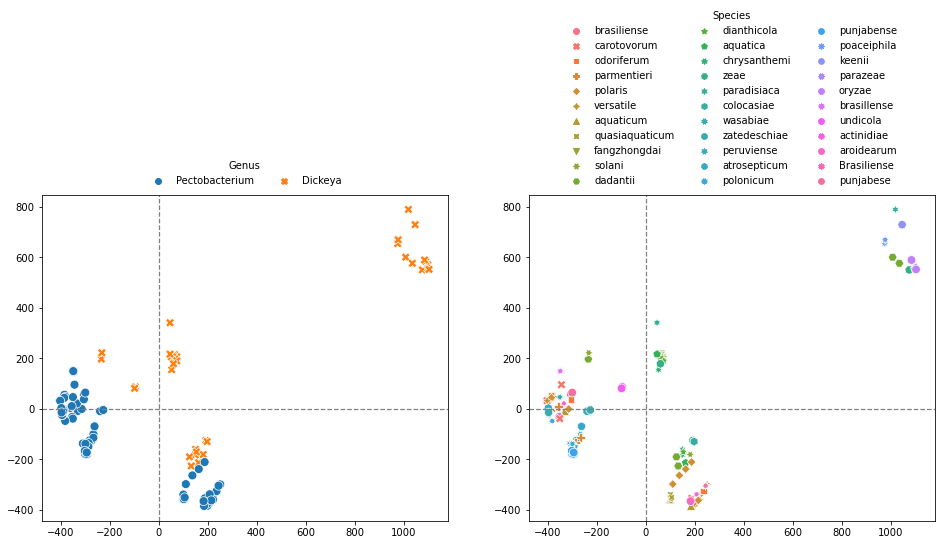

In [15]:
plot_mds(scaled_df_1, biolog_df_gs_sys_1, list(biolog_df['Genus']), list(biolog_df['Species']))

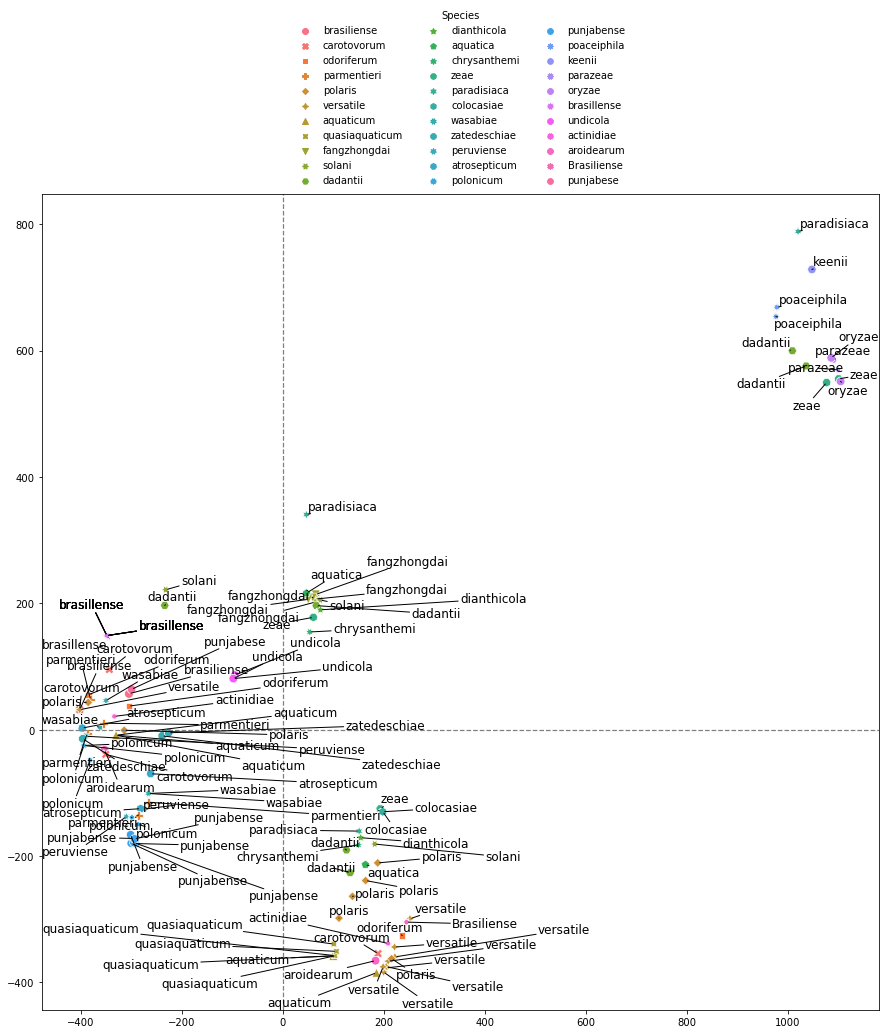

In [20]:
plt.figure(figsize=(15,15))

s_mds_scatter = sns.scatterplot(
    x=scaled_df_1[:,0],
    y=scaled_df_1[:,1],
    data=biolog_df_gs_sys_1,
    hue='Species',
    style='Species',
    s=80,
);

s_mds_scatter.axhline(0, linestyle='--', color='grey', linewidth=1.25);
s_mds_scatter.axvline(0, linestyle='--', color='grey', linewidth=1.25);
sns.move_legend(
    s_mds_scatter,
    "lower center",
    bbox_to_anchor=(.5, 1),
    ncol=3, 
    title='Species',
    frameon=False,
);
x_vals = scaled_df_1[:,0]
y_vals = scaled_df_1[:,1]
genome_lbls = list(biolog_df['Species'])
texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    )]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

In [44]:
# replace the symbols with the appropriate score
biolog_df_gs_sys_1 = copy(biolog_df_gs)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('0', 0)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('-', 0)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('w', 1)
biolog_df_gs_sys_1 = biolog_df_gs_sys_1.replace('+', 2)
biolog_df_gs_sys_1.head(3)

0                           1% NaCl  1% Sodium Lactate  3-O-Methyl-D-Glucose   
Genus          Species                                                         
Pectobacterium brasiliense        0                  0                     0  \
               carotovorum        0                  0                     0   
               odoriferum         0                  0                     0   

0                           4% NaCl  8% NaCl  Acetic Acid  Acetoacetic Acid   
Genus          Species                                                        
Pectobacterium brasiliense        2        0            0                 0  \
               carotovorum        2        0            0                 0   
               odoriferum         2        0            0                 0   

0                           Aztreonam  Bromo-Succinic Acid  Citric Acid  ...   
Genus          Species                                                   ...   
Pectobacterium brasiliense          0                    0            2  ...  \
               carotovorum          0                    0            2  ...   
               odoriferum           0                    0            2  ...   

0                           Ala-gly  Gly-asn  ethanolamine  agmatine  Ala-lue   
Genus          Species                                                          
Pectobacterium brasiliense        0        0             0         0        0  \
               carotovorum        0        0             0         0        0   
               odoriferum         0        0             0         0        0   

0                           allantoin  Ala-thr  M-TartaricAcid   
Genus          Species                                           
Pectobacterium brasiliense          0        0               0  \
               carotovorum          0        0               0   
               odoriferum           0        0               0   

0                           D-galactonic acid gamma-Lactone  Gly-Pro  
Genus          Species                                                
Pectobacterium brasiliense                                0        0  
               carotovorum                                0        0  
               odoriferum                                 0        0  

[3 rows x 265 columns]

In [45]:
scaler = StandardScaler()
scaler.fit(biolog_df_gs_sys_1)
X_scaled = scaler.transform(biolog_df_gs_sys_1)

mds_1 = MDS(random_state=0, normalized_stress='auto')  # embedding
scaled_df_1 = mds_1.fit_transform(X_scaled)
mds_1.stress_

189095.6363976812

<ipython-input-26-cf8ca9694057>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Genus'] = genus_col
<ipython-input-26-cf8ca9694057>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Species'] = species_col


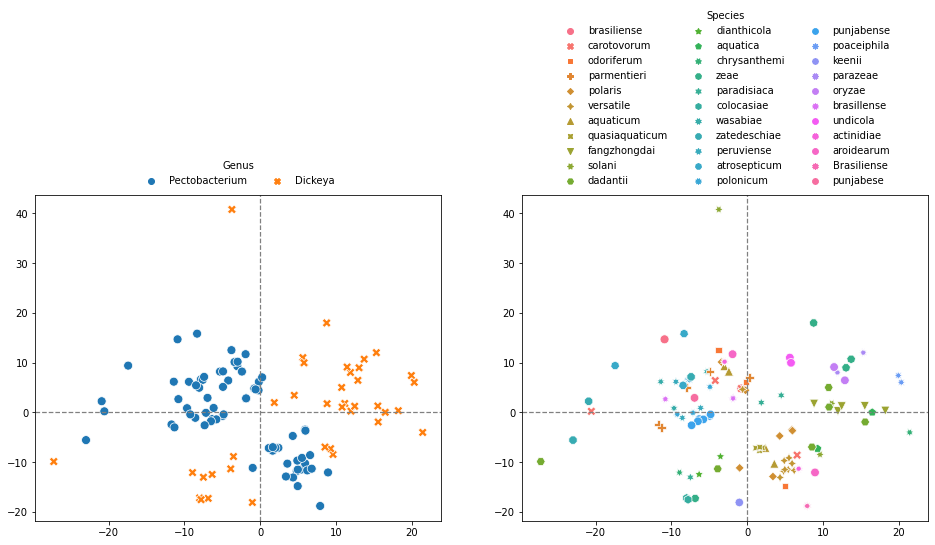

In [47]:
plot_mds(scaled_df_1, biolog_df_gs_sys_1, list(biolog_df['Genus']), list(biolog_df['Species']))

### Scoring system 2

* 2 - positive
* 1 - weak
* 0 - unknown / not recorded
* -1 - negative

In [48]:
# replace the symbols with the appropriate score
biolog_df_gs_sys_2 = copy(biolog_df_gs)
biolog_df_gs_sys_2 = biolog_df_gs_sys_2.replace('0', 0)
biolog_df_gs_sys_2 = biolog_df_gs_sys_2.replace('-', -1)
biolog_df_gs_sys_2 = biolog_df_gs_sys_2.replace('w', 1)
biolog_df_gs_sys_2 = biolog_df_gs_sys_2.replace('+', 2)
biolog_df_gs_sys_2.head(3)

0                           1% NaCl  1% Sodium Lactate  3-O-Methyl-D-Glucose   
Genus          Species                                                         
Pectobacterium brasiliense        0                  0                     0  \
               carotovorum        0                  0                     0   
               odoriferum         0                  0                     0   

0                           4% NaCl  8% NaCl  Acetic Acid  Acetoacetic Acid   
Genus          Species                                                        
Pectobacterium brasiliense        2        0            0                 0  \
               carotovorum        2        0            0                 0   
               odoriferum         2        0            0                 0   

0                           Aztreonam  Bromo-Succinic Acid  Citric Acid  ...   
Genus          Species                                                   ...   
Pectobacterium brasiliense         -1                    0            2  ...  \
               carotovorum         -1                    0            2  ...   
               odoriferum          -1                    0            2  ...   

0                           Ala-gly  Gly-asn  ethanolamine  agmatine  Ala-lue   
Genus          Species                                                          
Pectobacterium brasiliense        0        0             0         0        0  \
               carotovorum        0        0             0         0        0   
               odoriferum         0        0             0         0        0   

0                           allantoin  Ala-thr  M-TartaricAcid   
Genus          Species                                           
Pectobacterium brasiliense          0        0               0  \
               carotovorum          0        0               0   
               odoriferum           0        0               0   

0                           D-galactonic acid gamma-Lactone  Gly-Pro  
Genus          Species                                                
Pectobacterium brasiliense                                0        0  
               carotovorum                                0        0  
               odoriferum                                 0        0  

[3 rows x 265 columns]

In [50]:
scaler = StandardScaler()
scaler.fit(biolog_df_gs_sys_2)
X_scaled = scaler.transform(biolog_df_gs_sys_2)

mds_2 = MDS(random_state=0, normalized_stress='auto')  # embedding
scaled_df_2 = mds_2.fit_transform(X_scaled)
mds_2.stress_

228107.91655528697

<ipython-input-26-cf8ca9694057>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Genus'] = genus_col
<ipython-input-26-cf8ca9694057>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Species'] = species_col


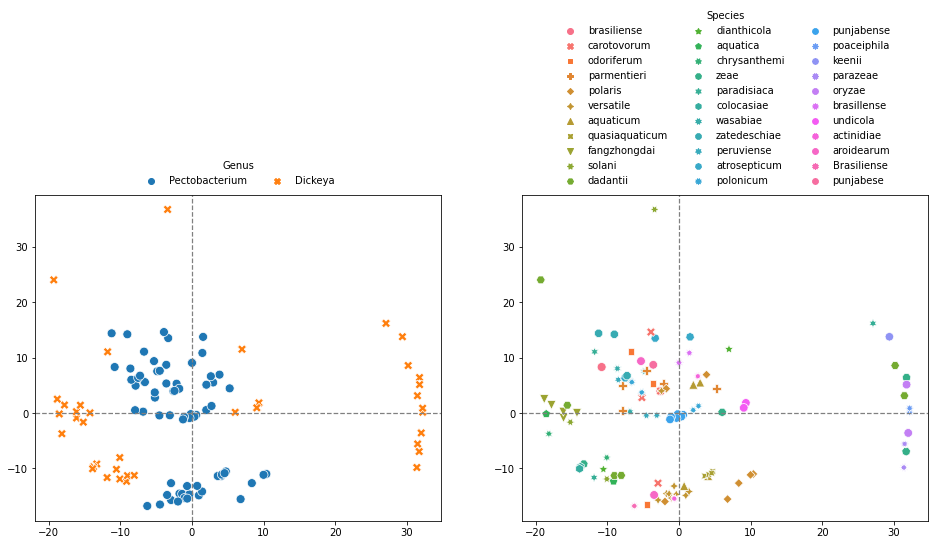

In [51]:
plot_mds(scaled_df_2, biolog_df_gs_sys_2, list(biolog_df['Genus']), list(biolog_df['Species']))

### Scoring system 3

* 2 - positive
* 1 - weak
* 0 - unknown / not recorded
* -2 - negative

In [52]:
# replace the symbols with the appropriate score
biolog_df_gs_sys_3 = copy(biolog_df_gs)
biolog_df_gs_sys_3 = biolog_df_gs_sys_3.replace('0', 0)
biolog_df_gs_sys_3 = biolog_df_gs_sys_3.replace('-', -2)
biolog_df_gs_sys_3 = biolog_df_gs_sys_3.replace('w', 1)
biolog_df_gs_sys_3 = biolog_df_gs_sys_3.replace('+', 2)
biolog_df_gs_sys_3.head(3)

0                           1% NaCl  1% Sodium Lactate  3-O-Methyl-D-Glucose   
Genus          Species                                                         
Pectobacterium brasiliense        0                  0                     0  \
               carotovorum        0                  0                     0   
               odoriferum         0                  0                     0   

0                           4% NaCl  8% NaCl  Acetic Acid  Acetoacetic Acid   
Genus          Species                                                        
Pectobacterium brasiliense        2        0            0                 0  \
               carotovorum        2        0            0                 0   
               odoriferum         2        0            0                 0   

0                           Aztreonam  Bromo-Succinic Acid  Citric Acid  ...   
Genus          Species                                                   ...   
Pectobacterium brasiliense         -2                    0            2  ...  \
               carotovorum         -2                    0            2  ...   
               odoriferum          -2                    0            2  ...   

0                           Ala-gly  Gly-asn  ethanolamine  agmatine  Ala-lue   
Genus          Species                                                          
Pectobacterium brasiliense        0        0             0         0        0  \
               carotovorum        0        0             0         0        0   
               odoriferum         0        0             0         0        0   

0                           allantoin  Ala-thr  M-TartaricAcid   
Genus          Species                                           
Pectobacterium brasiliense          0        0               0  \
               carotovorum          0        0               0   
               odoriferum           0        0               0   

0                           D-galactonic acid gamma-Lactone  Gly-Pro  
Genus          Species                                                
Pectobacterium brasiliense                                0        0  
               carotovorum                                0        0  
               odoriferum                                 0        0  

[3 rows x 265 columns]

In [53]:
scaler = StandardScaler()
scaler.fit(biolog_df_gs_sys_3)
X_scaled = scaler.transform(biolog_df_gs_sys_3)

mds_3 = MDS(random_state=0, normalized_stress='auto')  # embedding
scaled_df_3 = mds_3.fit_transform(X_scaled)
mds_3.stress_

215447.51929879253

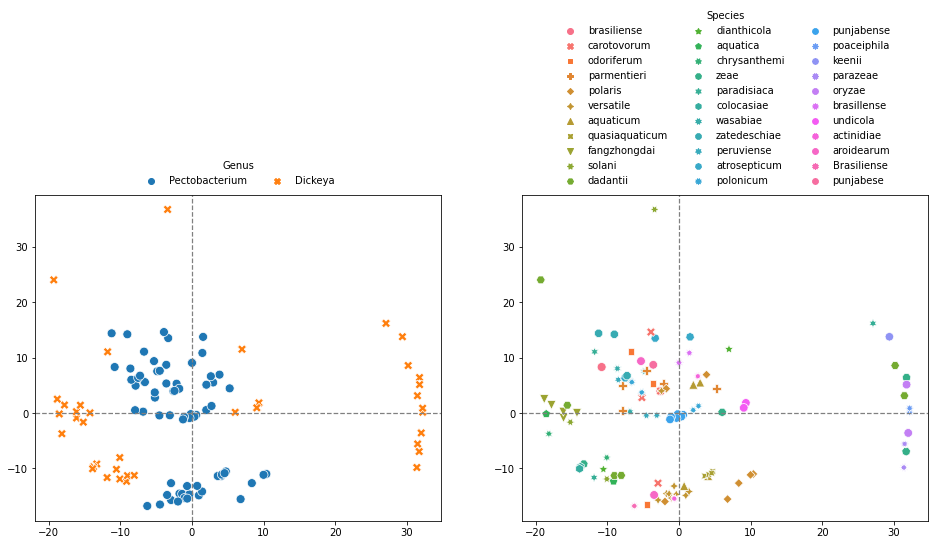

In [54]:
plot_mds(scaled_df_2, biolog_df_gs_sys_2, list(biolog_df['Genus']), list(biolog_df['Species']))

# Explore the data set - Are all conditions needed?

The stress index for the MDS outputs above are extremely high. 

MDS (and other manifold learning methods) are sentivie to noise. 

The BIOLOG data could contain a noteable amount of noise from variation between machines, preparation of the samples, and interpretaiton/reporting of the BIOLOG output. Noise can ‘short-circuit’ MDS, bridging genmes together that would otherwise be well-separated.

Additionally, noise could be generated, or distances articially inflated by the provisions of results for a given condition for only a limited number of genomes in the dataset.

How many conditions are tested across 100, 90, 80, 70, 60 and 50% of the genomes?

In [23]:
condition_representation = {}  # {condition: {'total': int, 'perc': perc of all genomes}}
total_genomes = len(biolog_df_gs)
for condition in tqdm(list(biolog_df_gs.columns), desc="Calculating representation"):
    tested = 0
    for v in list(biolog_df_gs[condition]):
        if str(v) != '0':
            tested += 1
    
    condition_representation[condition] = {
        'total': tested,
        'perc': (tested/total_genomes)*100,
    }
condition_representation

Calculating representation:   0%|          | 0/265 [00:00<?, ?it/s]

{'1% NaCl': {'total': 35, 'perc': 29.166666666666668},
 '1% Sodium Lactate': {'total': 35, 'perc': 29.166666666666668},
 '3-O-Methyl-D-Glucose': {'total': 21, 'perc': 17.5},
 '4% NaCl': {'total': 71, 'perc': 59.166666666666664},
 '8% NaCl': {'total': 53, 'perc': 44.166666666666664},
 'Acetic Acid': {'total': 91, 'perc': 75.83333333333333},
 'Acetoacetic Acid': {'total': 77, 'perc': 64.16666666666667},
 'Aztreonam': {'total': 71, 'perc': 59.166666666666664},
 'Bromo-Succinic Acid': {'total': 59, 'perc': 49.166666666666664},
 'Citric Acid': {'total': 106, 'perc': 88.33333333333333},
 'D-Arabitol': {'total': 91, 'perc': 75.83333333333333},
 'D-Aspartic Acid': {'total': 62, 'perc': 51.66666666666667},
 'D-Cellobiose': {'total': 97, 'perc': 80.83333333333333},
 'D-Fructose': {'total': 62, 'perc': 51.66666666666667},
 'D-Fructose-6-Phosphate': {'total': 49, 'perc': 40.833333333333336},
 'D-Fucose': {'total': 74, 'perc': 61.66666666666667},
 'D-Galactose': {'total': 80, 'perc': 66.66666666666

In [57]:
less_than_90_representation = []
for condition in condition_representation:
    if condition_representation[condition]['perc'] < 90:
        # print(condition, f"{round(condition_representation[condition]['perc'], 2)}%")
        less_than_90_representation.append(condition)
    else:
        print(condition, f"{round(condition_representation[condition]['perc'], 2)}%")
print(f'> In total {len(less_than_90_representation)} conditions out of {len(biolog_df_rgs.columns)} are tested in <90% of the genomes')

D-Glucuronic Acid 93.33%
Inosine 90.83%
L-Glutamic Acid 95.0%
> In total 255 conditions out of 265 are tested in <90% of the genomes


In [61]:
less_than_75_representation = []
for condition in condition_representation:
    if condition_representation[condition]['perc'] < 75:
        less_than_75_representation.append(condition)
print(f'> In total {len(biolog_df_rgs.columns) - len(less_than_75_representation)} conditions out of {len(biolog_df_rgs.columns)} are tested in >=75% of the genomes')

> In total 18 conditions out of 265 are tested in >=75% of the genomes


In [26]:
less_than_50_representation = []
for condition in condition_representation:
    if condition_representation[condition]['perc'] < 50:
        less_than_50_representation.append(condition)
print(f'> In total {len(biolog_df_gs.columns) - len(less_than_50_representation)} conditions out of {len(biolog_df_gs.columns)} are tested in >=50% of the genomes')

> In total 59 conditions out of 265 are tested in >=50% of the genomes


## MDS conditions with >=50% representation

Initially try with scoring system 1.

In [27]:
try:
    biolog_df_gs_sys_1 = biolog_df_gs_sys_1.drop(['Genus','Species'],axis=1)
except KeyError:
    pass
biolog_df_gs_sys_1_50 = biolog_df_gs_sys_1[less_than_50_representation]
biolog_df_gs_sys_1_50.head(3)

0                           1% NaCl  1% Sodium Lactate  3-O-Methyl-D-Glucose   
Genus          Species                                                         
Pectobacterium brasiliense        0                  0                     0  \
               carotovorum        0                  0                     0   
               odoriferum         0                  0                     0   

0                           8% NaCl  Bromo-Succinic Acid   
Genus          Species                                     
Pectobacterium brasiliense        0                    0  \
               carotovorum        0                    0   
               odoriferum         0                    0   

0                           D-Fructose-6-Phosphate  D-Galacturonic Acid   
Genus          Species                                                    
Pectobacterium brasiliense                       0                    0  \
               carotovorum                       0                    0   
               odoriferum                        0                    0   

0                           D-Glucose-6-Phosphate  D-Malic Acid  D-Salicin   
Genus          Species                                                       
Pectobacterium brasiliense                      0             0          0  \
               carotovorum                      0             0          0   
               odoriferum                       0             0          0   

0                           ...  Ala-gly  Gly-asn  ethanolamine  agmatine   
Genus          Species      ...                                             
Pectobacterium brasiliense  ...        0        0             0         0  \
               carotovorum  ...        0        0             0         0   
               odoriferum   ...        0        0             0         0   

0                           Ala-lue  allantoin  Ala-thr  M-TartaricAcid   
Genus          Species                                                    
Pectobacterium brasiliense        0          0        0               0  \
               carotovorum        0          0        0               0   
               odoriferum         0          0        0               0   

0                           D-galactonic acid gamma-Lactone  Gly-Pro  
Genus          Species                                                
Pectobacterium brasiliense                                0        0  
               carotovorum                                0        0  
               odoriferum                                 0        0  

[3 rows x 213 columns]

In [28]:
manhattan_50 = sklearn.metrics.pairwise.manhattan_distances(biolog_df_gs_sys_1_50)

In [30]:
mds_50 = MDS(random_state=0, normalized_stress='auto')  # embedding
scaled_df_50 = mds_50.fit_transform(manhattan_50)
mds_50.stress_

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


5652867.804585792

<ipython-input-6-cf8ca9694057>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Genus'] = genus_col
<ipython-input-6-cf8ca9694057>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gs['Genus'] = genus_col
<ipython-input-6-cf8ca9694057>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

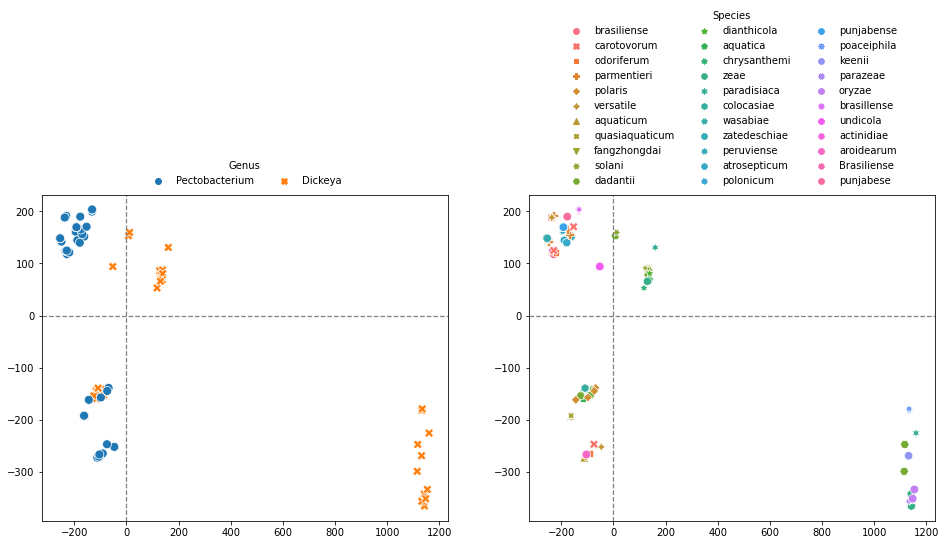

In [31]:
plot_mds(scaled_df_50, biolog_df_gs_sys_1_50, list(biolog_df['Genus']), list(biolog_df['Species']))

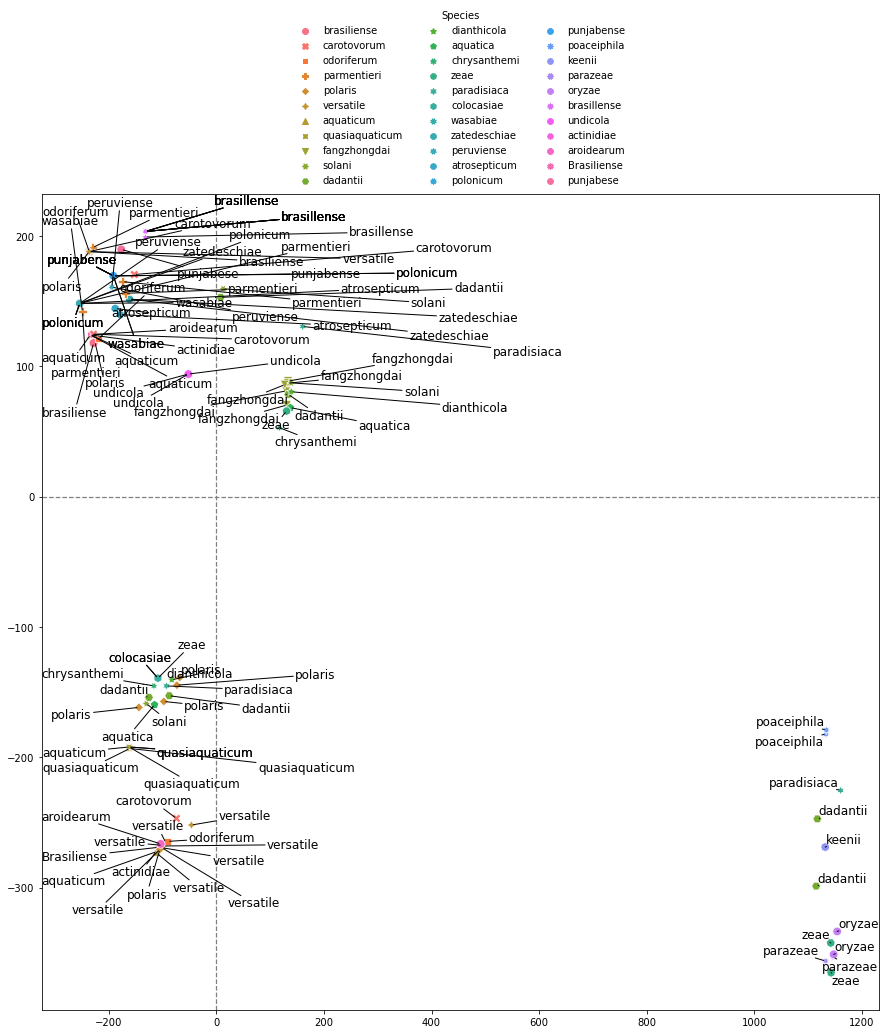

In [32]:
plt.figure(figsize=(15,15))

s_mds_scatter = sns.scatterplot(
    x=scaled_df_50[:,0],
    y=scaled_df_50[:,1],
    data=biolog_df_gs_sys_1,
    hue='Species',
    style='Species',
    s=80,
);

s_mds_scatter.axhline(0, linestyle='--', color='grey', linewidth=1.25);
s_mds_scatter.axvline(0, linestyle='--', color='grey', linewidth=1.25);
sns.move_legend(
    s_mds_scatter,
    "lower center",
    bbox_to_anchor=(.5, 1),
    ncol=3, 
    title='Species',
    frameon=False,
);
x_vals = scaled_df_50[:,0]
y_vals = scaled_df_50[:,1]
genome_lbls = list(biolog_df['Species'])
texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    )]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

In [39]:
mds_50?

In [40]:
mds_50.get_params()

{'dissimilarity': 'euclidean',
 'eps': 0.001,
 'max_iter': 300,
 'metric': True,
 'n_components': 2,
 'n_init': 4,
 'n_jobs': None,
 'normalized_stress': 'auto',
 'random_state': 0,
 'verbose': 0}

In [43]:
mds_50.get_metadata_routing()

AttributeError: 'MDS' object has no attribute 'get_metadata_routing'

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [85]:
scaler = StandardScaler()
scaler.fit(biolog_df_gs_sys_1_50)
X_scaled = scaler.transform(biolog_df_gs_sys_1_50)

mds_1 = MDS(random_state=0, normalized_stress='auto')  # embedding
scaled_df_1_50 = mds_1.fit_transform(X_scaled)
mds_1.stress_

102888.49069039541

<ipython-input-26-cf8ca9694057>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gs['Genus'] = genus_col
<ipython-input-26-cf8ca9694057>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gs['Genus'] = genus_col
<ipython-input-26-cf8ca9694057>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

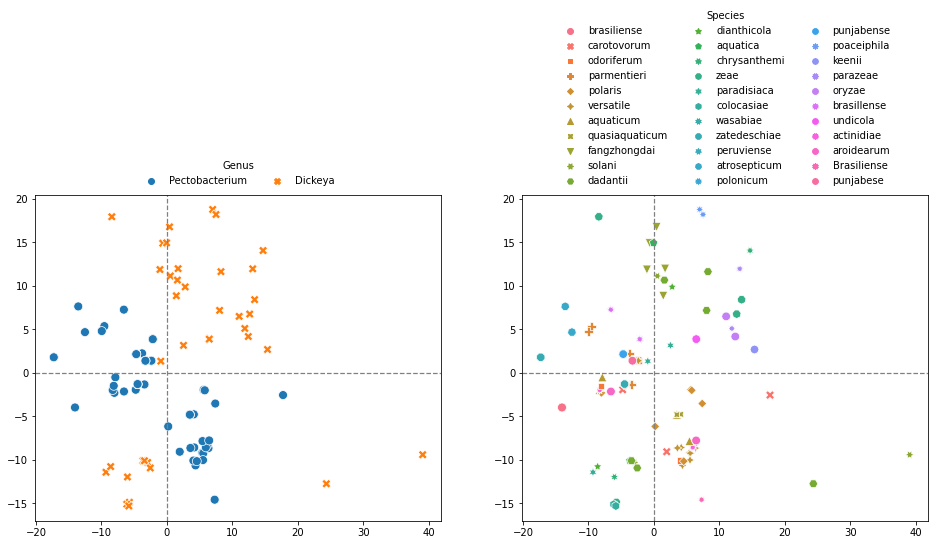

In [86]:
plot_mds(scaled_df_1_50, biolog_df_gs_sys_1_50, list(biolog_df['Genus']), list(biolog_df['Species']))

In [ ]:
mds_1 = MDS(random_state=0, normalized_stress='auto')  # embedding
scaled_df_1 = mds_1.fit_transform(manhattan)
mds_1.stress_
plot_mds(scaled_df_1, biolog_df_gs_sys_1, list(biolog_df['Genus']), list(biolog_df['Species']))

# Prinpal Component Analysis

Perform Principal Component Analysis (PCA) across the entire data set and only conditions tested in >= 50% of the genomes.

### All conditions

In [83]:
try:
    biolog_df_gs_sys_1 = biolog_df_gs_sys_1.drop(['Genus','Species'], axis=1)
except KeyError:
    pass
num_of_components = len(biolog_df_gs_sys_1)
a_pca, a_X_scaled = perform_pca(biolog_df_gs_sys_1, num_of_components)
a_pca

PCA(n_components=120)

Number of features needed to explain 0.95 fraction of total variance is 35. 


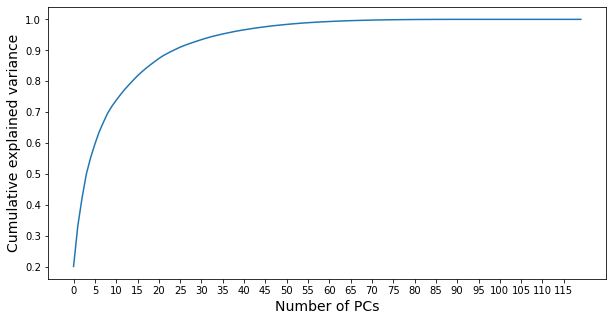

In [87]:
cumExpVar = plot_explained_variance(
    a_pca,
    num_of_components,
)

In [88]:
print(f"{a_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

100.0% of the variance in the data set was catpured by the PCA


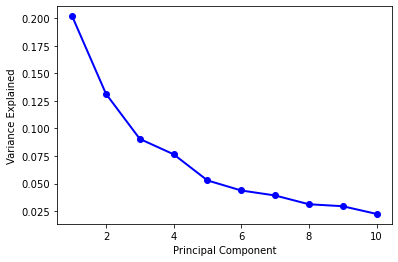

Explained variance for 1PC: 0.20182304819788321
Explained variance for 2PC: 0.13143379573381558
Explained variance for 3PC: 0.09052117850548924
Explained variance for 4PC: 0.07658452649107583
Explained variance for 5PC: 0.05288994508813579
Explained variance for 6PC: 0.04374944389313533
Explained variance for 7PC: 0.039239383137825386
Explained variance for 8PC: 0.03127527392448981
Explained variance for 9PC: 0.02947822880378421
Explained variance for 10PC: 0.02250103047528195


In [89]:
plot_scree(a_pca, nComp=10)

Explore PCs 1-4, which capture 8-35% of the diversity in the data set.

<ipython-input-90-8950a9188548>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  biolog_df_rgs['Genus'] = list(biolog_df['Genus'])


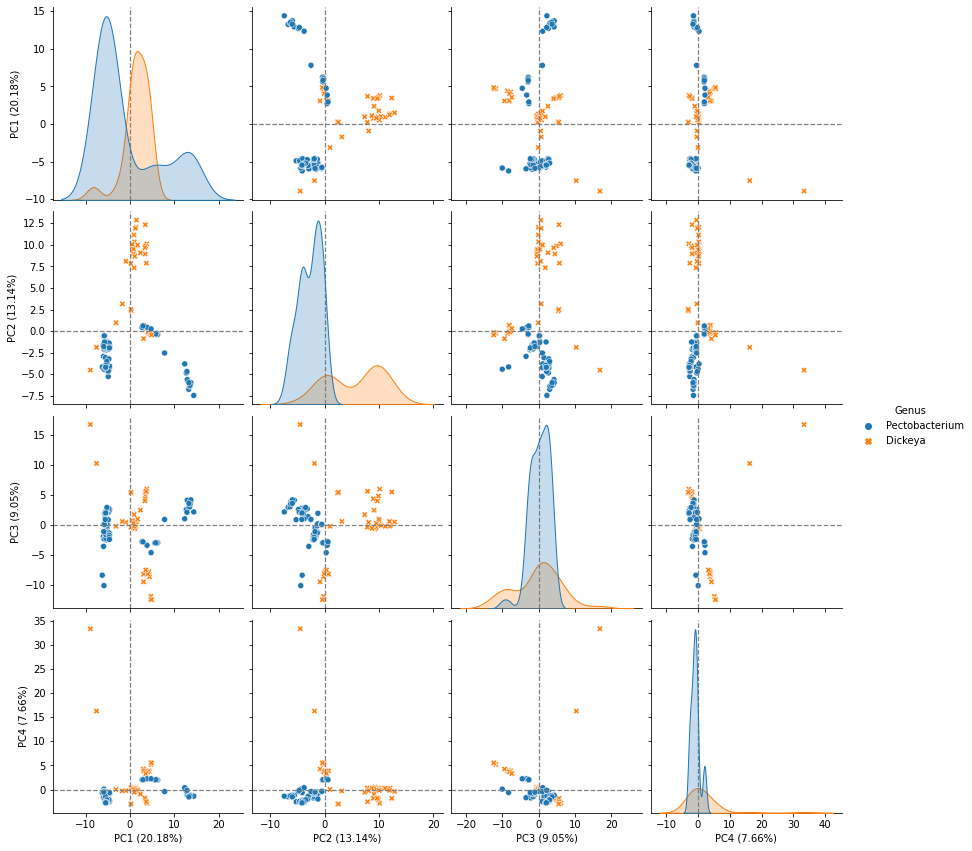

In [90]:
biolog_df_gs['Genus'] = list(biolog_df['Genus'])

X_pca = a_pca.transform(a_X_scaled)

pc_temp_df = copy(biolog_df_gs)
colnames = []
for i in range(4):
    col_name = f'PC{i+1} ({round(a_pca.explained_variance_ratio_[i] * 100, 2)}%)'
    pc_temp_df[col_name] = X_pca[:,i]
    colnames.append(col_name)

g = sns.pairplot(
    pc_temp_df[(['Genus']+colnames)],
    vars=colnames,
    hue="Genus",
    diag_kind="kde",
    markers=['o','X'],
    height=3,
);

i = 0
for ax in g.axes.ravel():
    if ax is None:
        continue
    if i not in [0,5,10,15]:
        ax.axhline(0, linestyle='--', color='grey', linewidth=1.25);
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    else:
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    i += 1

<ipython-input-91-36a8b72dbe7a>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  biolog_df_gs['Species'] = list(biolog_df['Species'])


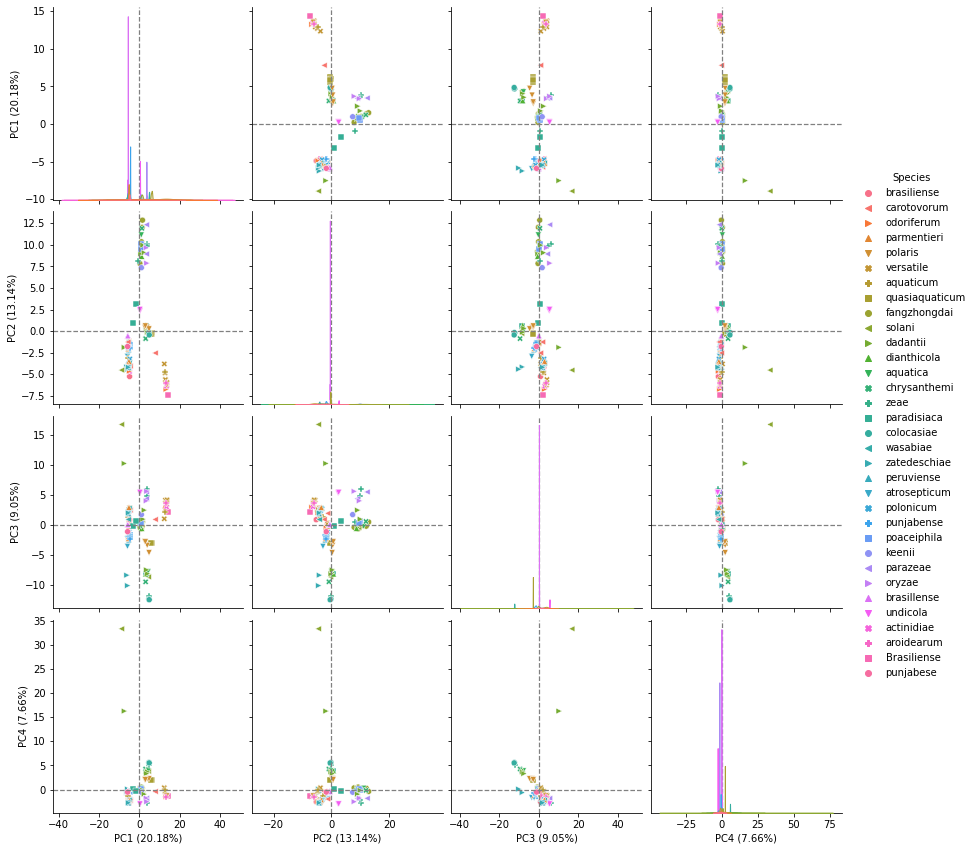

In [91]:
biolog_df_gs['Species'] = list(biolog_df['Species'])

X_pca = a_pca.transform(a_X_scaled)

pc_temp_df = copy(biolog_df_gs)
colnames = []
for i in range(4):
    col_name = f'PC{i+1} ({round(a_pca.explained_variance_ratio_[i] * 100, 2)}%)'
    pc_temp_df[col_name] = X_pca[:,i]
    colnames.append(col_name)

g = sns.pairplot(
    pc_temp_df[(['Species']+colnames)],
    vars=colnames,
    hue="Species",
    diag_kind="kde",
    height=3,
    markers=['o','<','>','^','v','X','P','s',
    'o','<','>','^','v','X','P','s',
    'o','<','>','^','v','X','P','s',
    'o','<','>','^','v','X','P','s', 'o'],
);

i = 0
for ax in g.axes.ravel():
    if ax is None:
        continue
    if i not in [0,5,10,15]:
        ax.axhline(0, linestyle='--', color='grey', linewidth=1.25);
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    else:
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    i += 1

### Conditions with >=50% representation

In [92]:
biolog_df_gs_sys_1_50 = biolog_df_50_gs.drop(['Genus', 'Species'], axis=1)
biolog_df_50_gs = biolog_df_50_gs.fillna(0)
num_of_components = len(biolog_df_50_gs.columns)
c_pca, c_X_scaled = perform_pca(biolog_df_50_gs, num_of_components)
c_pca

NameError: name 'biolog_df_50_gs' is not defined

In [ ]:
cumExpVar = plot_explained_variance(
    c_pca,
    num_of_components,
)

In [ ]:
print(f"{c_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

In [ ]:
plot_scree(c_pca, nComp=10)

In [ ]:
biolog_df_50_gs['Genus'] = list(biolog_df_50['Genus'])

c_X_pca = c_pca.transform(c_X_scaled)

c_pc_temp_df = copy(biolog_df_50_gs)
c_colnames = []
for i in range(4):
    col_name = f'PC{i+1} ({round(c_pca.explained_variance_ratio_[i] * 100, 2)}%)'
    c_pc_temp_df[col_name] = c_X_pca[:,i]
    c_colnames.append(col_name)

g = sns.pairplot(
    c_pc_temp_df[(['Genus']+c_colnames)],
    vars=c_colnames,
    hue="Genus",
    diag_kind="kde",
    markers=['o','X'],
    height=3,
);

i = 0
for ax in g.axes.ravel():
    if ax is None:
        continue
    if i not in [0,5,10,15]:
        ax.axhline(0, linestyle='--', color='grey', linewidth=1.25);
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    else:
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    i += 1

In [ ]:
biolog_df_50_gs['Species'] = list(biolog_df_50['Species'])

c_X_pca = c_pca.transform(c_X_scaled)

c_pc_temp_df = copy(biolog_df_50_gs)
c_colnames = []
for i in range(4):
    col_name = f'PC{i+1} ({round(c_pca.explained_variance_ratio_[i] * 100, 2)}%)'
    c_pc_temp_df[col_name] = c_X_pca[:,i]
    c_colnames.append(col_name)

g = sns.pairplot(
    c_pc_temp_df[(['Species']+c_colnames)],
    vars=c_colnames,
    hue="Species",
    diag_kind="kde",
    height=3,
    markers=['o','<','>','^','v','X','P','s',
    'o','<','>','^','v','X','P','s',
    'o','<','>','^','v','X','P','s',
    'o','<','>','^','v','X','P','s', 'o'],
);

i = 0
for ax in g.axes.ravel():
    if ax is None:
        continue
    if i not in [0,5,10,15]:
        ax.axhline(0, linestyle='--', color='grey', linewidth=1.25);
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    else:
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    i += 1

In [ ]:
bio